In [1]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import pickle as pkl
import datetime
import json
import time
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','nature', 'no-latex'])

from statsmodels.stats.weightstats import ztest, ttest_ind
from interpret.glassbox import ExplainableBoostingClassifier
import subprocess

pd.options.mode.chained_assignment = None
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
%matplotlib inline
%load_ext autoreload
%autoreload 2
from plotnine import *

import sys
import os
sys.path.append('../src')
sys.path.append('../slicefinder')
from slice_finder import SliceFinder
from clustering_analysis import ClusteringEstimator
from stability_analysis import LatentSubgroupShiftEstimator
import utils
import sirus
from sklearn.model_selection import GridSearchCV


# Load Data

In [2]:
df = pd.read_csv('/gpfs_projects/adarsh.subbaswamy/mimic/model_dataset.csv')
df = df.set_index('subject_id')
subject_ids = df.index.values

In [3]:
df.head()

,mort_hosp,heart rate min,heart rate max,systolic blood pressure min,systolic blood pressure max,temperature min,temperature max,blood urea nitrogen min,blood urea nitrogen max,white blood cell count min,...,partial pressure of oxygen max,fraction inspired oxygen min,fraction inspired oxygen max,AIDS,metastatic cancer,hematologic malignancy,age,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT
subject_id,,,,,,,,,,,,,,,,,,,,,
3,0,78.0,153.75,64.0,129.00,36.055578,37.400001,42.0,53.0,12.7,...,287.0,-9999.0,-9999.0,0,0,0,76.526792,0,1,0
4,0,74.0,105.50,97.0,139.00,36.333318,37.444423,10.0,10.0,9.7,...,-9999.0,-9999.0,-9999.0,1,0,0,47.845047,0,1,0
6,0,76.0,100.00,125.0,175.00,36.055578,37.333317,62.0,65.0,10.6,...,-9999.0,-9999.0,-9999.0,0,0,0,65.942297,1,0,0
9,1,83.5,111.00,133.0,188.75,35.500000,37.888894,16.0,17.0,7.5,...,106.0,-9999.0,-9999.0,0,0,0,41.790228,0,1,0
11,0,70.0,97.00,91.0,118.00,36.333318,37.388896,14.0,19.0,9.3,...,-9999.0,-9999.0,-9999.0,0,0,0,50.148295,0,1,0


In [4]:
df.columns

Index(['mort_hosp', 'heart rate min', 'heart rate max',
       'systolic blood pressure min', 'systolic blood pressure max',
       'temperature min', 'temperature max', 'blood urea nitrogen min',
       'blood urea nitrogen max', 'white blood cell count min',
       'white blood cell count max', 'potassium min', 'potassium max',
       'sodium min', 'sodium max', 'bicarbonate min', 'bicarbonate max',
       'bilirubin min', 'bilirubin max', 'glascow coma scale total min',
       'glascow coma scale total max', 'partial pressure of oxygen min',
       'partial pressure of oxygen max', 'fraction inspired oxygen min',
       'fraction inspired oxygen max', 'AIDS', 'metastatic cancer',
       'hematologic malignancy', 'age', 'admission_type_ELECTIVE',
       'admission_type_EMERGENCY', 'admission_type_URGENT'],
      dtype='object')

In [69]:
df.mort_hosp.mean()

0.09588204501832141

In [5]:
train_ids, test_ids = train_test_split(subject_ids, test_size=0.2, random_state=123)

In [6]:
X_train = df.loc[train_ids].drop(columns='mort_hosp').values
y_train = df.loc[train_ids]['mort_hosp'].values
X_test = df.loc[test_ids].drop(columns='mort_hosp').values
y_test = df.loc[test_ids]['mort_hosp'].values

# Train Study Model

In [7]:
model = ExplainableBoostingClassifier(feature_names = df.drop(columns='mort_hosp').columns.values)
# model = LogisticRegression(max_iter=10000)

In [8]:
%%time
model.fit(X_train, y_train)

CPU times: user 1.47 s, sys: 2.18 s, total: 3.65 s
Wall time: 17.5 s


ExplainableBoostingClassifier(feature_names=array(['heart rate min', 'heart rate max', 'systolic blood pressure min',
       'systolic blood pressure max', 'temperature min',
       'temperature max', 'blood urea nitrogen min',
       'blood urea nitrogen max', 'white blood cell count min',
       'white blood cell count max', 'potassium min', 'potassium max',
       'sodium min', 'sodium max', 'bicarbonate min', 'bicarbonate max',
       'bilirubin min', 'bilirubin max', 'glascow coma scale total min',
       'glascow coma scale total max', 'partial pressure of oxygen min',
       'partial pressure of oxygen max', 'fraction inspired oxygen min',
       'fraction inspired oxygen max', 'AIDS', 'metastatic cancer',
       'hematologic malignancy', 'age', 'admission_type_ELECTIVE',
       'admission_type_EMERGENCY', 'admission_type_URGENT'], dtype=object))

# Collect Subgroup Features

In [9]:
test_preds = model.predict_proba(X_test)[:, 1]

In [10]:
print(f'Model AUROC = {roc_auc_score(y_test, test_preds):.2}')

Model AUROC = 0.89


In [11]:
candidate_shortcuts_df = pd.read_csv('/gpfs_projects/adarsh.subbaswamy/mimic/candidate_shortcuts.csv')
candidate_shortcuts_df = candidate_shortcuts_df.set_index('subject_id')

In [12]:
candidate_shortcuts_df.head()

,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,ethnicity_ASIAN - FILIPINO,ethnicity_ASIAN - JAPANESE,ethnicity_ASIAN - KOREAN,ethnicity_ASIAN - OTHER,...,temperature missing,blood urea nitrogen missing,white blood cell count missing,potassium missing,sodium missing,bicarbonate missing,bilirubin missing,glascow coma scale total missing,partial pressure of oxygen missing,fraction inspired oxygen missing
subject_id,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [13]:
candidate_shortcuts_df.sum()

ethnicity_AMERICAN INDIAN/ALASKA NATIVE                                  15
ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE        2
ethnicity_ASIAN                                                         542
ethnicity_ASIAN - ASIAN INDIAN                                           49
ethnicity_ASIAN - CAMBODIAN                                              10
                                                                      ...  
bicarbonate missing                                                     376
bilirubin missing                                                     20050
glascow coma scale total missing                                      14956
partial pressure of oxygen missing                                    23295
fraction inspired oxygen missing                                      26622
Length: 72, dtype: int64

In [14]:
%%time
DATA_FILEPATH = '/gpfs_projects/adarsh.subbaswamy/mimic/all_hourly_data.h5'
# All flattened version
vitals  = pd.read_hdf(DATA_FILEPATH, 'vitals_labs')
# flatten multi index
vitals.columns = [' '.join(col).strip() for col in vitals.columns.values]
vitals = vitals.reset_index()
statics = pd.read_hdf(DATA_FILEPATH, 'patients').reset_index()
icd_codes = pd.read_hdf(DATA_FILEPATH, 'codes').reset_index()
treatments = pd.read_hdf(DATA_FILEPATH, 'interventions').reset_index()

CPU times: user 9.72 s, sys: 10.9 s, total: 20.6 s
Wall time: 1min 6s


In [15]:
statics.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'ethnicity', 'age',
       'insurance', 'admittime', 'diagnosis_at_admission', 'dischtime',
       'discharge_location', 'fullcode_first', 'dnr_first', 'fullcode', 'dnr',
       'dnr_first_charttime', 'timecmo_chart', 'cmo_first', 'cmo_last', 'cmo',
       'deathtime', 'intime', 'outtime', 'los_icu', 'admission_type',
       'first_careunit', 'mort_icu', 'mort_hosp', 'hospital_expire_flag',
       'hospstay_seq', 'readmission_30', 'max_hours'],
      dtype='object')

In [16]:
static_features = ['gender', 'ethnicity', 'age', 'insurance', 'first_careunit', 'admission_type']

In [17]:
subgroup_feature_data = statics.set_index('subject_id').loc[test_ids].reset_index()[static_features]

In [18]:
ethnicities = subgroup_feature_data.ethnicity.values
ethnicities = ['BLACK'  if 'BLACK' in x else x for x in ethnicities]
ethnicities = ['ASIAN'  if 'ASIAN' in x else x for x in ethnicities]
ethnicities = ['HISPANIC'  if 'HISPANIC' in x else x for x in ethnicities]
ethnicities = ['WHITE'  if 'WHITE' in x else x for x in ethnicities]
ethnicities = ['WHITE'  if 'PORTUGUESE' in x else x for x in ethnicities]
ethnicities = ['ASIAN'  if 'PACIFIC' in x else x for x in ethnicities]
ethnicities = ['WHITE'  if 'MIDDLE EASTERN' in x else x for x in ethnicities]
ethnicities = ['OTHER'  if x in ['OTHER', 'UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER', 'MULTI RACE ETHNICITY'] else x for x in ethnicities]
ethnicities = ['BLACK'  if 'CARIBBEAN ISLAND' in x else x for x in ethnicities]
ethnicities = ['OTHER'  if 'NATIVE' in x else x for x in ethnicities]



In [19]:
# collapse "URGENT" and "EMERGENCY" categories
admit_types = subgroup_feature_data.admission_type.values
admit_types = ['EMERGENCY' if 'URGENT' in x else x for x in admit_types]
subgroup_feature_data['admission_type'] = admit_types

In [20]:
subgroup_feature_data['ethnicity'] = ethnicities

In [21]:
subgroup_feature_data = pd.get_dummies(subgroup_feature_data, 
                                       columns =['ethnicity', 'insurance', 'first_careunit'],
                                       dtype=np.int64)
subgroup_feature_data = pd.get_dummies(subgroup_feature_data, columns=['gender', 'admission_type'], drop_first=True,
                                      dtype=np.int64)

In [71]:
subgroup_feature_data

,age,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_OTHER,ethnicity_WHITE,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,gender_M,admission_type_EMERGENCY
0,65.352359,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
1,83.669330,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
2,18.430821,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1
3,71.932332,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
4,58.531104,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6873,300.002998,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
6874,59.478219,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1
6875,60.222792,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1
6876,300.002599,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


In [22]:
hinge_auc_loss = utils.torch_roc_auc_surrogate(y_test, test_preds, 'hinge')

In [23]:
test_loss = hinge_auc_loss # utils.cross_entropy(y_test, test_preds)

# Run AFISP Step 1

In [24]:
%%time
stability_analysis = LatentSubgroupShiftEstimator(cv=5, 
                                                  verbose=True, 
                                                  eps=1e-5, 
                                                  subset_fractions=np.arange(0.05, 1, 0.05)
                                                 )
sa_risks = stability_analysis.fit(subgroup_feature_data.values, test_loss)

k = 0
k = 1
k = 2
k = 3
k = 4
CPU times: user 1.12 s, sys: 57.4 ms, total: 1.18 s
Wall time: 10.6 s


In [25]:
sa_masks = stability_analysis.subset_masks()

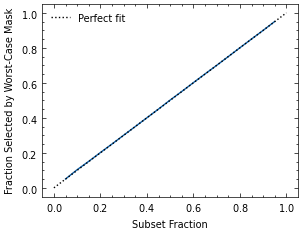

In [26]:
_ = stability_analysis.check_subset_sizes()

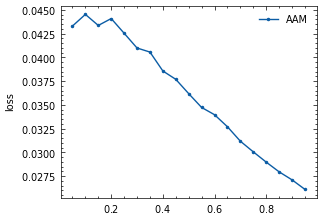

In [28]:
# Check that loss increases as worst-performing subset size gets smaller
plt.plot(stability_analysis.subset_fractions, sa_risks, '.-', label='AAM')
plt.ylabel('loss')
plt.legend(loc='best')

In [29]:
subpop_aucs = []
news_aucs = []
for m in sa_masks:
    subpop_aucs.append(roc_auc_score(y_test[m], test_preds[m]))

In [78]:
subpop_aucs[-1], subpop_aucs[0]

(0.879656779661017, 0.795682302771855)

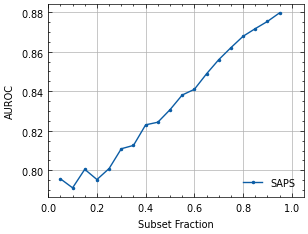

In [30]:
plt.plot(stability_analysis.subset_fractions, subpop_aucs, '.-', label='SAPS')
# plt.fill_between(stability_analysis.subset_fractions, roc_ci[:, 0], roc_ci[:, 1], alpha=0.25)

# plt.plot(alphas, news_aucs, label='NEWS (Baseline)')
plt.ylabel('AUROC')
plt.xlabel('Subset Fraction')
plt.legend(loc='lower right')
plt.xlim(0, 1.05)
plt.grid()

19it [00:08,  2.35it/s]


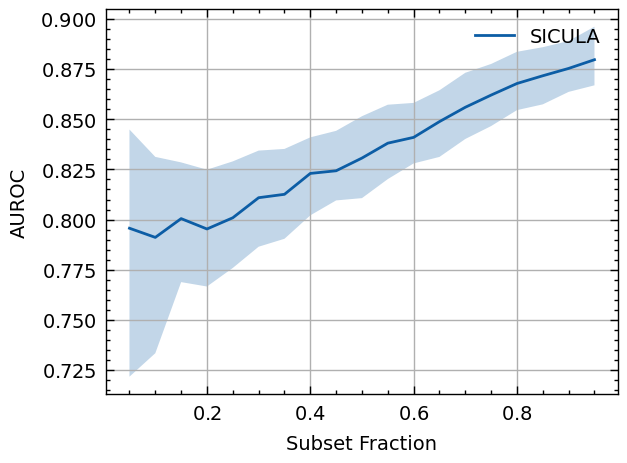

In [67]:
# can also compute bootstrap confidence intervals
bootstrap_cis = np.zeros((len(sa_masks), 2))
for i, alpha in tqdm(enumerate(stability_analysis.subset_fractions)):
    mask = sa_masks[i]
    mean, upper, lower = utils.bootstrap_ci(y_test[mask], test_preds[mask], loss=roc_auc_score)
    bootstrap_cis[i, 0] = lower
    bootstrap_cis[i, 1] = upper

plt.plot(stability_analysis.subset_fractions, subpop_aucs, label='SICULA')
plt.fill_between(stability_analysis.subset_fractions,
                 bootstrap_cis[:, 0], 
                 bootstrap_cis[:, 1], 
                 alpha=0.25)
plt.xlabel('Subset Fraction')
plt.ylabel('AUROC')
plt.legend(loc='best')
plt.grid()
plt.savefig('figs/mimic_curve.pdf', dpi=360)
plt.show()

In [80]:
stability_analysis.subset_fractions

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

## Select subset fraction based on max effect size

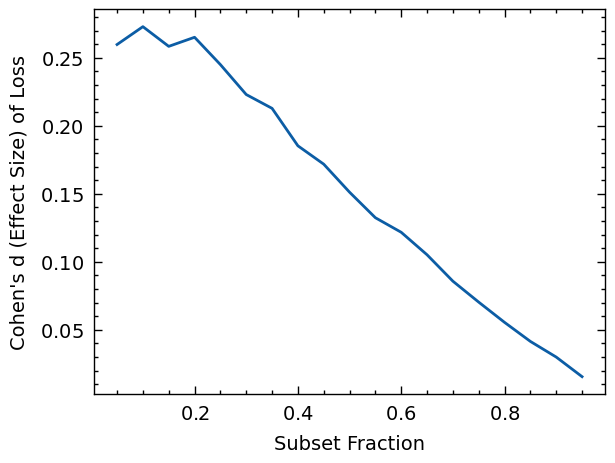

In [142]:
cds = []
p_vals = []

for i, a in enumerate(stability_analysis.subset_fractions):
    idxs = sa_masks[i]
    odxs = ~sa_masks[i]
    cds.append(sirus.cohens_d(test_loss[idxs], test_loss))
    pval = ttest_ind(test_loss[idxs], 
                         x2=test_loss[odxs], 
                         value=0.,
                         alternative='larger',
                         usevar='unequal')[1]
    p_vals.append(pval)
        
    
plt.plot(stability_analysis.subset_fractions, cds)
plt.xlabel('Subset Fraction')
plt.ylabel('Cohen\'s d (Effect Size) of Loss')
plt.savefig('figs/effect_size.pdf', dpi=360)
plt.show()

In [148]:
max_ind, max_cd = sirus.find_max_effect_size(sa_masks, test_loss)
print(max_ind, stability_analysis.subset_fractions[max_ind], max_cd)

1 0.1 0.27287521128332626


In [34]:
phenotype_df = subgroup_feature_data.copy()

In [35]:
phenotype_df['subset_label'] = sa_masks[max_ind]*1

In [36]:
df_fname = "tmp/mimic_for_sirus.csv"
phenotype_df.to_csv("tmp/mimic_for_sirus.csv", index=False)

## Run stability analysis

In [37]:
%%time
depth = 3
rule_max = 50
sirus_rules_fname = f"tmp/mimic_sirus_rules_{rule_max}_rules_{depth}_depth.txt"

subprocess.call((f"/home/adarsh.subbaswamy/anaconda3/envs/afisp/bin/Rscript" 
f" run_sirus.r" 
f" --input {df_fname} "
f" --output {sirus_rules_fname}"
f" --depth {depth}"
f" --rule.max {rule_max}"
f" --cv"),
shell=True)

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


[1] 3
[1] "Running cross-validation 1/10 ..."
[1] "Running cross-validation 2/10 ..."
[1] "Running cross-validation 3/10 ..."
[1] "Running cross-validation 4/10 ..."
[1] "Running cross-validation 5/10 ..."
[1] "Running cross-validation 6/10 ..."
[1] "Running cross-validation 7/10 ..."
[1] "Running cross-validation 8/10 ..."
[1] "Running cross-validation 9/10 ..."
[1] "Running cross-validation 10/10 ..."
[1] "p0="
[1] 0.02264503
[1] "Number of trees:  1000  - Stability  87.11  %."
[1] "Number of trees:  2000  - Stability  91.08  %."
[1] "Number of trees:  3000  - Stability  93.05  %."
[1] "Number of trees:  4000  - Stability  93.79  %."
[1] "Number of trees:  5000  - Stability  94.48  %."
[1] "Number of trees:  6000  - Stability  94.96  %."
[1] "Number of trees:  7000  - Stability  95.08  %."
CPU times: user 139 ms, sys: 73.7 ms, total: 212 ms
Wall time: 9min 54s


0

# AFISP Step 2: Subgroup phenotyping

In [38]:
sirus_rules = sirus.get_sirus_rules(sirus_rules_fname)
rule_p_values = sirus.precompute_p_values(sirus_rules, phenotype_df, test_loss)
significant_rules = sirus.holm_bonferroni_correction(rule_p_values)

extracted_rules = sirus.effect_size_filtering(significant_rules, phenotype_df, test_loss, 
                                                  effect_threshold=0.3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 151.11it/s]


28 ('ethnicity_OTHER >= 1', 0.005831779343294062, 1016) 0.004545454545454546


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 177.43it/s]


In [39]:
extracted_rules

['insurance_Medicare >= 1 & first_careunit_CCU < 1 & first_careunit_CSRU < 1',
 'age >= 66.1 & first_careunit_CSRU < 1 & admission_type_EMERGENCY >= 1',
 'age >= 75.8 & insurance_Medicare >= 1 & first_careunit_CSRU < 1',
 'insurance_Medicare >= 1 & first_careunit_CSRU < 1 & admission_type_EMERGENCY >= 1',
 'age >= 66.1 & first_careunit_CSRU < 1',
 'age >= 66.1 & admission_type_EMERGENCY >= 1']

In [40]:
r_aucs = []
r_ls = []
r_us = []
ns = []

for rule in tqdm(extracted_rules):
    rows = phenotype_df.eval(str(rule))
    ns.append(np.sum(rows))
    m, l, u = utils.bootstrap_ci(y_test[rows], test_preds[rows], loss=roc_auc_score)
    r_aucs.append(m)
    r_ls.append(l)
    r_us.append(u)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.74it/s]


In [41]:
aam_sirus_df = pd.DataFrame(
    {
        'Phenotype': extracted_rules, 
        'AUROC': r_aucs, 
        'N': ns, 
        'Lower': r_ls, 
        'Upper': r_us
    }).sort_values(by='AUROC')

In [74]:
pd.set_option('display.max_colwidth', None)
aam_sirus_df
# aam_sirus_df[['Phenotype']]

,Phenotype,AUROC,N,Lower,Upper
2,age >= 75.8 & insurance_Medicare >= 1 & first_careunit_CSRU < 1,0.808089,1570,0.780545,0.832698
0,insurance_Medicare >= 1 & first_careunit_CCU < 1 & first_careunit_CSRU < 1,0.813889,2208,0.790170,0.831200
1,age >= 66.1 & first_careunit_CSRU < 1 & admission_type_EMERGENCY >= 1,0.817458,2439,0.795068,0.838656
3,insurance_Medicare >= 1 & first_careunit_CSRU < 1 & admission_type_EMERGENCY >= 1,0.818443,2673,0.796085,0.843817
4,age >= 66.1 & first_careunit_CSRU < 1,0.822388,2636,0.800820,0.842749
5,age >= 66.1 & admission_type_EMERGENCY >= 1,0.828145,2887,0.807707,0.844812


# Run  slicefinder

In [43]:
%%time
sfX = subgroup_feature_data.copy()
sfX.columns = [x.replace(' ', '_') for x in sfX.columns]
sf = SliceFinder(None, (sfX, pd.DataFrame({'y': y_test})))
d1_slices = sf.slicing(False)
d2_slices = sf.crossing(d1_slices, 2)
d3_slices = sf.crossing(d2_slices, 3)
candidate_slices = d1_slices + d2_slices + d3_slices
print("Slices acquired")
# candidate_rules = [sirus.slice_to_equality_rule(s) for s in candidate_slices]

# rule_p_values = sirus.precompute_p_values(candidate_rules, sfX, test_loss)
# significant_rules = sirus.holm_bonferroni_correction(rule_p_values)

# sf_extracted_rules = sirus.effect_size_filtering(significant_rules, sfX, test_loss, 
#                                               effect_threshold=0.4)

Slices acquired
CPU times: user 1min 23s, sys: 1.68 s, total: 1min 25s
Wall time: 1min 25s


In [44]:
len(candidate_slices)

225151

In [45]:
%%time
sf_candidate_rules = [sirus.custom_slice_to_rule(s) for s in candidate_slices]

sf_rule_p_values = sirus.parallel_precompute_p_values(sf_candidate_rules, sfX, test_loss, n_jobs=32)

# sf_rule_p_values = sirus.precompute_p_values(sf_candidate_rules, sfX, test_loss)

sf_significant_rules = sirus.holm_bonferroni_correction(sf_rule_p_values)

sf_extracted_rules = sirus.effect_size_filtering(sf_significant_rules, sfX, test_loss, 
                                              effect_threshold=0.3)
# significant_rules = sirus.holm_bonferroni_correction(rule_p_values)

# sf_extracted_rules = sirus.effect_size_filtering(significant_rules, sfX, test_loss, 
#                                               effect_threshold=0.4)

/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:190: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:190: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
/home/adarsh.subbaswamy/anaconda3/envs/afisp/lib/python3.10/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encounte

29884 ('((age <= 70.75652361488586 and age >= 18.1801526136806) or (age <= 306.413119906092 and age >= 75.76314468228271)) and (insurance_Self_Pay == 0) and (first_careunit_MICU == 1)', 2.6587962501474146e-07, 2176) 2.649441762620616e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████| 29883/29883 [04:28<00:00, 111.32it/s]

CPU times: user 22min 10s, sys: 4min 13s, total: 26min 23s
Wall time: 25min 2s


In [46]:
len(sf_significant_rules), len(sf_extracted_rules)

(29883, 328)

In [47]:
r_rs = []
r_aucs = []
r_ls = []
r_us = []
ns = []

for rule in tqdm(sf_extracted_rules):
    rows = sfX.eval(str(rule))
    
    if all(x==1 for x in y_test[rows]) or all(x==0 for x in y_test[rows]):
        continue
    # m = roc_auc_score(y_test[rows], test_preds[rows])
    
    m, l, u = utils.bootstrap_ci(y_test[rows], test_preds[rows], loss=roc_auc_score)
    ns.append(np.sum(rows))

    r_aucs.append(m)
    r_ls.append(l)
    r_us.append(u)
    r_rs.append(rule)
    
sf_sirus_df = pd.DataFrame(
    {
        'Phenotype': r_rs, 
        'AUROC': r_aucs, 
        'N': ns, 
        'Lower': r_ls, 
        'Upper': r_us
    }).sort_values(by='AUROC')

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [02:02<00:00,  2.67it/s]


In [85]:
sf_sirus_df.query("N >= 400")

,Phenotype,AUROC,N,Lower,Upper,Similarity,Jaccard
316,((age <= 306.413119906092 and age >= 80.40680469945148) or (age <= 306.413119906092 and age >= 85.50666837684687)) and (first_careunit_MICU == 1) and (admission_type_EMERGENCY == 1),0.768662,519,0.712261,0.810730,0.990447,0.714286
321,(age <= 306.413119906092 and age >= 85.50666837684687) and (first_careunit_CSRU == 0) and ((ethnicity_OTHER == 0)),0.774167,552,0.722291,0.825633,0.991579,0.753794
320,(age <= 306.413119906092 and age >= 85.50666837684687) and (ethnicity_OTHER == 0) and ((first_careunit_CSRU == 0)),0.775371,552,0.726134,0.822134,0.991579,0.753794
78,(age <= 306.413119906092 and age >= 85.50666837684687) and (first_careunit_CSRU == 0) and ((first_careunit_CCU == 0)),0.779009,481,0.727144,0.826875,0.988817,0.753794
77,(age <= 306.413119906092 and age >= 85.50666837684687) and (first_careunit_CCU == 0) and ((first_careunit_CSRU == 0)),0.779119,481,0.730188,0.822284,0.988817,0.753794
...,...,...,...,...,...,...,...
314,(age <= 306.413119906092 and age >= 61.158241760359) and (admission_type_EMERGENCY == 1) and ((first_careunit_CSRU == 0)),0.828532,2877,0.806146,0.843117,0.961266,0.271471
311,((age <= 306.413119906092 and age >= 61.158241760359) or (age <= 306.413119906092 and age >= 75.76314468228271)) and (first_careunit_CSRU == 0) and (admission_type_EMERGENCY == 1),0.829005,2877,0.812236,0.849241,0.961266,0.271309
312,((age <= 306.413119906092 and age >= 61.158241760359) or (age <= 306.413119906092 and age >= 80.40680469945148)) and (first_careunit_CSRU == 0) and (admission_type_EMERGENCY == 1),0.829571,2877,0.807451,0.848278,0.961266,0.271309
313,((age <= 306.413119906092 and age >= 61.158241760359) or (age <= 306.413119906092 and age >= 85.50666837684687)) and (first_careunit_CSRU == 0) and (admission_type_EMERGENCY == 1),0.829607,2877,0.810755,0.847168,0.961266,0.271309


# Compare AFISP and Slicefinder Results

In [49]:
from sklearn.metrics import jaccard_score
sf_idxs = set()
afisp_idxs = set()
for rule in tqdm(sf_extracted_rules):
    sf_idxs.update(sfX.query(str(rule)).index)

for rule in tqdm(extracted_rules):
    afisp_idxs.update(subgroup_feature_data.query(str(rule)).index)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 113.60it/s]


In [50]:

afisp_rule_idxs = []
for rule in tqdm(extracted_rules):
    afisp_rule_idxs.append(subgroup_feature_data.eval(str(rule)) * 1)

sf_rule_jaccards = []

for rule in tqdm(sf_extracted_rules):
    sf_rule_idxs = sfX.eval(str(rule)) * 1
    sf_rule_jaccards.append(max([jaccard_score(sf_rule_idxs, ax) for ax in afisp_rule_idxs]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:15<00:00, 20.50it/s]


In [100]:
n_random_slices = 500
random_slices = np.random.choice(sf_candidate_rules, size=n_random_slices, replace=False)

In [101]:
augmented_slice_matrix = np.zeros((len(X_test), len(sf_sirus_df) + len(aam_sirus_df) + len(random_slices)))

for j, r in tqdm(enumerate(sf_sirus_df.Phenotype.values)):
    indicators = sfX.eval(r) * 1
    augmented_slice_matrix[:, j] = indicators
    
for j, r in tqdm(enumerate(aam_sirus_df.Phenotype.values)):
    indicators = phenotype_df.eval(r) * 1
    augmented_slice_matrix[:, len(sf_sirus_df) + j] = indicators

for j, r in tqdm(enumerate(random_slices)):
    indicators = sfX.eval(r) * 1
    augmented_slice_matrix[:, len(sf_sirus_df) + len(aam_sirus_df) + j] = indicators

328it [00:02, 112.58it/s]
6it [00:00, 140.71it/s]
500it [00:04, 106.10it/s]


In [102]:
%%time
from sklearn.model_selection import GridSearchCV

# perform PLS; use CV to pick num components
plsr = PLSRegression()
cv = GridSearchCV(plsr, cv=5, param_grid = {
    'n_components':list(range(2, 10))
}, verbose=0, n_jobs=32, scoring="neg_mean_squared_error")
cv.fit(augmented_slice_matrix, test_loss)

CPU times: user 5.03 s, sys: 8.57 s, total: 13.6 s
Wall time: 13 s


GridSearchCV(cv=5, estimator=PLSRegression(), n_jobs=32,
             param_grid={'n_components': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [103]:
cv.best_estimator_.n_components

2

In [104]:
# plsr = PLSRegression(n_components=cv.best_estimator_.n_components)
plsr = PLSRegression(n_components=2)
plsr.fit(augmented_slice_matrix, test_loss)
plsr_X, plsr_Y = plsr.transform(augmented_slice_matrix, test_loss)

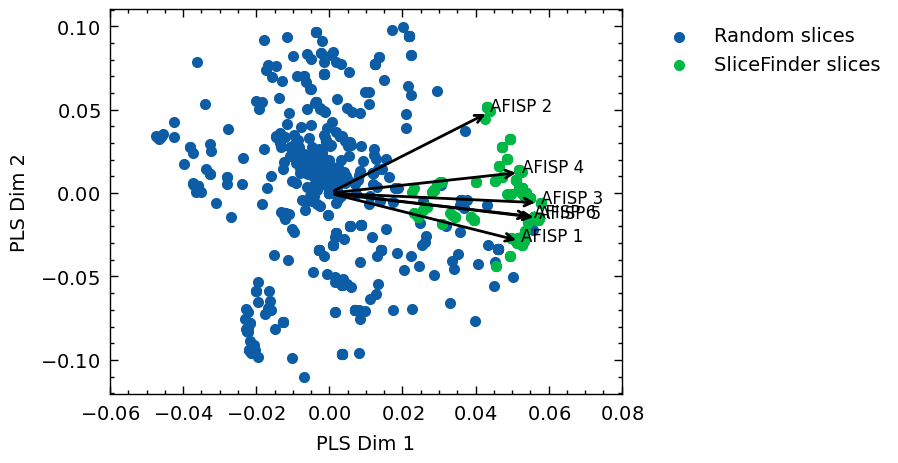

In [115]:
pca_embeddings = plsr.x_loadings_ # pca.components_.T
plt.scatter(pca_embeddings[-len(random_slices):, 0], pca_embeddings[-len(random_slices):, 1], label="Random slices")
plt.scatter(pca_embeddings[:len(sf_sirus_df), 0], pca_embeddings[:len(sf_sirus_df), 1], label="SliceFinder slices")


for i in range(len(aam_sirus_df)):
    x = pca_embeddings[len(sf_sirus_df) + i, 0]
    y = pca_embeddings[len(sf_sirus_df) + i, 1]
    plt.annotate("", xy=pca_embeddings[len(sf_sirus_df) + i], 
                 xytext=(0,0), 
                 arrowprops=dict(arrowstyle="->", color='k', linewidth=1))
    plt.text(x, y, f"AFISP {i+1}", size=6)
    # plt.arrow(0, 0, pca_embeddings[len(sf_sirus_df) + i, 0], pca_embeddings[len(sf_sirus_df) + i, 1])
# plt.scatter(pca_embeddings[-len(aam_sirus_df):, 0], 
#             pca_embeddings[-len(aam_sirus_df):, 1], 
#             label="AFISP rules")

plt.xlabel("PLS Dim 1")
plt.ylabel("PLS Dim 2")
plt.xlim(-0.06, 0.08)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig("figs/mimic-pls.pdf", dpi=240)
plt.show()